# Train model to recognise voice of people 

In [2]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
from enum import Enum
import pandas as pd
from pathlib import Path
from torchvision.transforms.functional import normalize
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
import sys
sys.path.append('../')

In [4]:
def filter_sample_by_clients_ids(data: pd.DataFrame, max_count: int = 500, min_count: int = 4):
	sample_count = data['client_id'].value_counts()
	clients_ids = [e for e in sample_count[sample_count < max_count][sample_count > min_count].index]
	return data[data['client_id'].isin(clients_ids)]

def concatenation(train_data: pd.DataFrame, anchor: pd.DataFrame, posneg: pd.DataFrame) -> pd.DataFrame:
		data_particle_case = pd.DataFrame(columns=['anchor_client_id', 'anchor_path', 'posneg_client_id', 'posneg_path', 'anchor_source', 'posneg_source'])
		data_particle_case[['anchor_client_id', 'anchor_path', 'anchor_source']] = anchor
		data_particle_case[['posneg_client_id', 'posneg_path', 'posneg_source']] = posneg
		return pd.concat([train_data, data_particle_case], ignore_index=True)


def generate_combined_dataset(original_data: pd.DataFrame, generated_data: pd.DataFrame, data_frac: int = 0.5) -> pd.DataFrame:
	client_ids = original_data['client_id'].unique()
	original_data['source'] = 'original'
	generated_data['source'] = 'generated'
	
	train_data = pd.DataFrame(columns=['anchor_client_id', 'anchor_path', 'posneg_client_id', 'posneg_path', 'anchor_source', 'posneg_source'])
	for id in client_ids:

		original_id_sample = original_data[original_data['client_id'] == id]
		generated_id_sample = generated_data[generated_data['client_id'] == id]
		original_no_client_id_sample = original_data[original_data['client_id'] != id]

		anchor_original = original_id_sample.sample(frac=data_frac).reset_index(drop=True)
		positive_original = original_id_sample.sample(frac=data_frac).reset_index(drop=True)
		train_data = concatenation(train_data, anchor_original, positive_original)


		anchor_original = original_id_sample.sample(frac=data_frac).reset_index(drop=True)
		negative_original = original_no_client_id_sample.sample(frac=data_frac).reset_index(drop=True)
		train_data = concatenation(train_data, anchor_original, negative_original)

		anchor_original = original_id_sample.sample(frac=data_frac).reset_index(drop=True)
		positive_original = original_id_sample.sample(frac=data_frac).reset_index(drop=True)
		train_data = concatenation(train_data, anchor_original, positive_original)

		anchor_original = original_id_sample.sample(frac=data_frac).reset_index(drop=True)
		negative_generated = generated_id_sample.sample(frac=data_frac).reset_index(drop=True)
		train_data = concatenation(train_data, anchor_original, negative_generated)
	
	return train_data

In [5]:
SAMPLE_RATE = 16000
DATASET_PATH = '../dataset/'
DATA_PATH = '../data/'
MODEL_SAVE_PATH = '../model_save/'
BATCH_SIZE = 24

In [6]:
from src.dataset.universal_dataset import UniversalDS

class UniversalCombinedDS(UniversalDS):

	def _get_label(self, anchor_client_id, posneg_client_id, anchor_source, posneg_source):
		label = anchor_client_id == posneg_client_id and anchor_source == posneg_source
		return torch.tensor(1 if label else 0, dtype=torch.int64)
	
	def mix_dataset(self):
		self.temp_dataset = generate_combined_dataset(self.voice_dataset, self.generated_voice_dataset, data_frac=1)
		self.reset_iteration()


In [7]:
import librosa

from src.columns.combined_dataset_column import CombinedDatasetColumn
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, ToMelSpectrogramTransform
import torch
from torch.utils.data import Dataset

from src.transform.composite_transformation import CompositeTransformation


class CombinedSoundDS(Dataset):
    def __init__(
        self,
        voiceDataset,
        original_voice_data_path,
        generated_voice_data_path,
        sample_rate=16000,
        duration=3,
        transform=None
    ):
        self.voiceDataset = voiceDataset
        self.original_voice_data_path = str(original_voice_data_path)
        self.generated_voice_data_path = str(generated_voice_data_path)
        self.duration = duration
        self.sample_rate = sample_rate
        self.transform = None
        if transform is not None:
            self.transform = transform
        else:
            self.transform = CompositeTransformation(
                [
                    ResampleTransform(target_sample_rate=sample_rate),
                    CustomAdjustDurationTransform(duration_seconds=duration),
                    ToMelSpectrogramTransform(
                        sample_rate=sample_rate, n_mels=64, n_fft=512)
                ]
            )

    def __len__(self):
        return len(self.voiceDataset)

    def _get_sgram(self, audio_file):
        audio, sample_rate = librosa.load(audio_file, sr=self.sample_rate)
        spectrogram = self.transform.transform((audio, sample_rate))
        return spectrogram

    def _get_label(self, anchor_client_id, posneg_client_id, anchor_source, posneg_source):
        label = anchor_client_id == posneg_client_id and anchor_source == posneg_source
        return torch.tensor(1 if label else 0, dtype=torch.int64)

    def _get_sample_path(self, path, source):
        data_path = self.original_voice_data_path if source == 'original' else self.generated_voice_data_path
        return data_path + path

    def __getitem__(self, idx):
        anchor_path, posneg_path, anchor_client_id, posneg_client_id, anchor_source, posneg_source = self.voiceDataset.iloc[idx][
            [
                CombinedDatasetColumn.ANCHOR_PATH,
                CombinedDatasetColumn.POSNEG_PATH,
                CombinedDatasetColumn.ANCHOR_ID,
                CombinedDatasetColumn.POSNEG_ID,
                CombinedDatasetColumn.SOURCE_ANCHOR,
                CombinedDatasetColumn.SOURCE_POSNEG
            ]
        ].values.tolist()

        anchor_file = self._get_sample_path(anchor_path, anchor_source)
        posneg_file = self._get_sample_path(posneg_path, posneg_source)
        label = self._get_label(
            anchor_client_id, posneg_client_id, anchor_source, posneg_source)
        anchor_sgram = self._get_sgram(anchor_file)
        posneg_sgram = self._get_sgram(posneg_file)

        return anchor_sgram, posneg_sgram, label

In [8]:
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, CustomAdjustDurationTransform, ShiftWrapperTransform, ToMelSpectrogramTransform, AirAbsorptionWrapperTransform, EqualizerWrapperTransform
from src.transform.composite_transformation import CompositeTransformation
SAMPLE_RATE = 16000
train_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3, padding_direction="start"),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
    AirAbsorptionWrapperTransform(),
    EqualizerWrapperTransform(),
		ToMelSpectrogramTransform(sample_rate=SAMPLE_RATE, n_mels=64, n_fft=512)
	]
)

test_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3, padding_direction="start"),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
    AirAbsorptionWrapperTransform(),
    EqualizerWrapperTransform(),
		ToMelSpectrogramTransform(sample_rate=SAMPLE_RATE, n_mels=64, n_fft=512)
	]
)

In [9]:
voice_df = pd.read_csv(DATA_PATH + "validated.tsv",  sep='\t')
voice_df = filter_sample_by_clients_ids(voice_df, min_count=3)[['client_id', 'path']]

generated_df = pd.read_csv(DATA_PATH + "generated.tsv",  sep='\t')
generated_df = filter_sample_by_clients_ids(generated_df, min_count=3)[['client_id', 'generated_path']]
train_ds = UniversalCombinedDS(voice_dataset=voice_df, generated_voice_dataset=generated_df, voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/", transform=train_transform)

test_df = pd.read_csv(DATASET_PATH + "test_combined_dataset.csv")
test_ds = CombinedSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/", transform=test_transform)

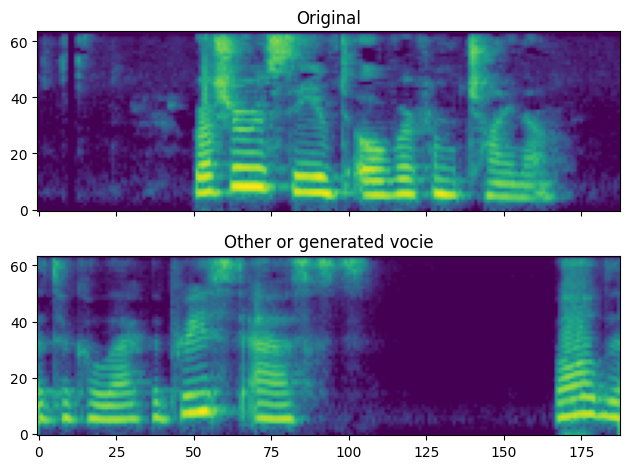

: 

In [54]:
from src.utils.plot import plot

plot(test_ds[111])
train_ds.reset_iteration()

In [ ]:
import torchvision
class SiameseNetwork(nn.Module):
		def __init__(self):
				super(SiameseNetwork, self).__init__()
				AlexNet = torchvision.models.alexnet(pretrained=True)
				self.conv_layers = AlexNet.features
				self.conv_layers[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
				self.avgpool = AlexNet.avgpool
				self.fc_layers = nn.Sequential(
						nn.Linear(9216, 1024),
						nn.ReLU(inplace=True),
				)

				self.final = nn.Linear(1024, 2)

		def forward_once(self, x):

				x = self.conv_layers(x)
				x = self.avgpool(x)
				x = x.view(x.size(0), -1)
				x = self.fc_layers(x)
				return x

		def forward(self, input1, input2):
			output1 = self.forward_once(input1)
			output2 = self.forward_once(input2)
			return self.final(torch.abs(output1 - output2))

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


def evaluate_siamese_model(model, dataloader, criterion, device='cpu'):
	model.eval()
	total_loss = 0.0
	predictions = []
	true_labels = []

	with torch.no_grad():
		for batch in tqdm(dataloader, desc="Evaluating", leave=False):
			anchor_sgram, posneg_sgram, label = batch
			anchor_sgram = anchor_sgram.to(device)
			posneg_sgram = posneg_sgram.to(device)
			label = label.to(device)
			output = model(anchor_sgram, posneg_sgram)
			loss = criterion(output, label)
			total_loss += loss.item()

			predictions += [torch.argmax(pred) for pred in output.cpu()]
			true_labels += [label.item() for label in label.cpu()]

	accuracy = accuracy_score(true_labels, predictions)
	precision = precision_score(true_labels, predictions)
	recall = recall_score(true_labels, predictions)
	f1 = f1_score(true_labels, predictions)

	avg_loss = total_loss / len(dataloader)

	return avg_loss, accuracy, precision, recall, f1

In [ ]:
def train_siamese_model(model, dataloader, criterion, optimizer, device='cpu'):
	model.train()
	total_loss = 0.0
	predictions = []
	true_labels = []

	for batch in tqdm(dataloader, desc="Training", leave=False):
		anchor_sgram, posneg_sgram, label = batch
		anchor_sgram = anchor_sgram.to(device)
		posneg_sgram = posneg_sgram.to(device)
		label = label.to(device)
		
		optimizer.zero_grad()
		output = model(anchor_sgram, posneg_sgram)
		loss = criterion(output, label)
		loss.backward()
		optimizer.step()
		total_loss += loss.item()
		predictions += [torch.argmax(pred) for pred in output.cpu()]
		true_labels += [label.item() for label in label.cpu()]

	accuracy = accuracy_score(true_labels, predictions)
	precision = precision_score(true_labels, predictions)
	recall = recall_score(true_labels, predictions)
	f1 = f1_score(true_labels, predictions)

	avg_loss = total_loss / len(dataloader)
	avg_loss = total_loss / len(dataloader)
	
	return avg_loss, accuracy, precision, recall, f1

In [ ]:
class CrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()

    def forward(self, output, label):
        label = label.long()
        loss = F.cross_entropy(output, label)
        return loss

In [ ]:
num_epochs = 10
siamese_model = SiameseNetwork().to('cuda')
criterion = CrossEntropyLoss().to('cuda')
optimizer = optim.Adam(siamese_model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\Yuriy\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Yuriy\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import copy
loss, accuracy, precision, recall, f1 = [], [], [], [], []
best_accuracy=0
for epoch in range(num_epochs):
	_train_loss, _train_accuracy, _train_precision, _train_recall, _train_f1 = train_siamese_model(siamese_model, train_dl, criterion, optimizer, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_train_loss:.4f}, "f"Accuracy: {_train_accuracy:.4f}, Precision: {_train_precision:.4f}, Recall: {_train_recall:.4f}, F1: {_train_f1:.4f}")
	_test_loss, _test_accuracy, _test_precision, _test_recall, _test_f1 = evaluate_siamese_model(siamese_model, test_dl, criterion, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_test_loss:.4f}, "f"Accuracy: {_test_accuracy:.4f}, Precision: {_test_precision:.4f}, Recall: {_test_recall:.4f}, F1: {_test_f1:.4f}")
	if _test_accuracy > best_accuracy:
		best_accuracy = _test_accuracy
		best_model = copy.deepcopy(siamese_model)
	loss.append([_train_loss, _test_loss])
	accuracy.append([_train_accuracy, _test_accuracy])
	precision.append([_train_precision, _test_precision])
	recall.append([_train_recall, _test_recall])
	f1.append([_train_f1, _test_f1])

Epoch 1/10, Loss: 0.7298, Accuracy: 0.6036, Precision: 0.6137, Recall: 0.5593, F1: 0.5852


Epoch 1/10, Loss: 0.6048, Accuracy: 0.6743, Precision: 0.6346, Recall: 0.8216, F1: 0.7161


Epoch 2/10, Loss: 0.5792, Accuracy: 0.6874, Precision: 0.6613, Recall: 0.7683, F1: 0.7108


Epoch 2/10, Loss: 0.7957, Accuracy: 0.6421, Precision: 0.8044, Recall: 0.3755, F1: 0.5120


Epoch 3/10, Loss: 0.5494, Accuracy: 0.7217, Precision: 0.7015, Recall: 0.7718, F1: 0.7350


Epoch 3/10, Loss: 0.4872, Accuracy: 0.7832, Precision: 0.7459, Recall: 0.8589, F1: 0.7985


Epoch 4/10, Loss: 0.5114, Accuracy: 0.7539, Precision: 0.7330, Recall: 0.7988, F1: 0.7645


Epoch 4/10, Loss: 0.5655, Accuracy: 0.6836, Precision: 0.6157, Recall: 0.9772, F1: 0.7554


Epoch 5/10, Loss: 0.6168, Accuracy: 0.6803, Precision: 0.6590, Recall: 0.7472, F1: 0.7003


Epoch 5/10, Loss: 0.5585, Accuracy: 0.7054, Precision: 0.6447, Recall: 0.9149, F1: 0.7564


Epoch 6/10, Loss: 0.4998, Accuracy: 0.7631, Precision: 0.7330, Recall: 0.8278, F1: 0.7775


Epoch 6/10, Loss: 0.4290, Accuracy: 0.8050, Precision: 0.7434, Recall: 0.9315, F1: 0.8269


Epoch 7/10, Loss: 0.4473, Accuracy: 0.7905, Precision: 0.7608, Recall: 0.8475, F1: 0.8018


Epoch 7/10, Loss: 0.4084, Accuracy: 0.8143, Precision: 0.7897, Recall: 0.8568, F1: 0.8219


Epoch 8/10, Loss: 0.4255, Accuracy: 0.8093, Precision: 0.7801, Recall: 0.8615, F1: 0.8188


Epoch 8/10, Loss: 0.3838, Accuracy: 0.8340, Precision: 0.7657, Recall: 0.9627, F1: 0.8529


Epoch 9/10, Loss: 0.4019, Accuracy: 0.8267, Precision: 0.7990, Recall: 0.8730, F1: 0.8344


Epoch 9/10, Loss: 0.4105, Accuracy: 0.8174, Precision: 0.7559, Recall: 0.9378, F1: 0.8370


Epoch 10/10, Loss: 0.3717, Accuracy: 0.8447, Precision: 0.8144, Recall: 0.8929, F1: 0.8519


Epoch 10/10, Loss: 0.4001, Accuracy: 0.8237, Precision: 0.7609, Recall: 0.9440, F1: 0.8426


In [ ]:
import matplotlib.pyplot as plt

def plot_metrix(loss, accuracy):
	epochs = range(1, len(loss) + 1)

	fig, axs = plt.subplots(2, 1, figsize=(12, 8))
	fig.suptitle("Model Metrics")


	axs[0].plot(epochs, [e[0] for e in loss], label=" Train loss", color="g")
	axs[0].plot(epochs, [e[1] for e in loss], label="Test loss", color="b")
	axs[0].set_title("Loss")
	axs[0].set_xlabel("Epoch")
	axs[0].set_ylabel("Loss")

	axs[1].plot(epochs, [e[0] for e in accuracy], label="Train accuracy", color="g")
	axs[1].plot(epochs, [e[1] for e in accuracy], label="Test accuracy", color="b")
	axs[1].set_title("Accuracy")
	axs[1].set_xlabel("Epoch")
	axs[1].set_ylabel("Accuracy")
	plt.tight_layout()
	plt.show()

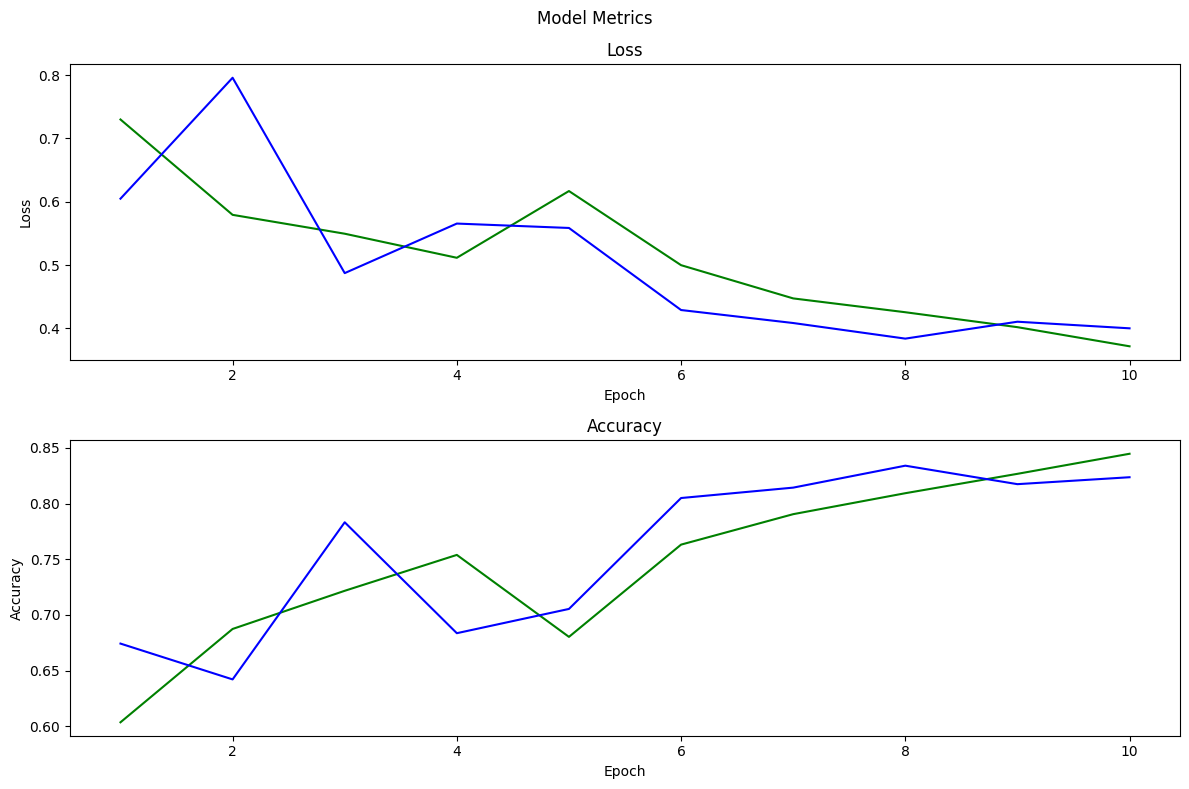

In [ ]:
plot_metrix(loss, accuracy)

In [ ]:
def save_model(model, model_name, base_path = '../model_save/'):
  model.cpu()
  model.eval()
  torch.save(model, base_path + model_name)

In [ ]:
save_model(siamese_model, "combined_cnn_mix.pt")

In [ ]:
def explain_model(model: torch.nn.Module, anchor_sgram: torch.tensor, posneg_sgram: torch.tensor, mode: str = "PREDICTED"):
	allowed_mode = ["GENERATED_CLASS, ORIGIN_CLASS", "PREDICTED"]
	if mode not in allowed_mode:
		raise ValueError()
	model.eval()
	model.cpu()
	model.zero_grad()
	anchor_sgram = torch.clone(anchor_sgram)
	posneg_sgram = torch.clone(posneg_sgram)

	anchor_sgram.unsqueeze_(0)
	posneg_sgram.unsqueeze_(0)
	anchor_sgram.requires_grad = True
	posneg_sgram.requires_grad = True

	anchor_sgram = anchor_sgram
	posneg_sgram = posneg_sgram

	predictions = model(anchor_sgram, posneg_sgram)
	if mode == "PREDICTED":
		class_id = predictions[0].argmax()
	if mode == "GENERATED_CLASS":
		class_id = 0
	if mode == "ORIGIN_CLASS":
		class_id = 1
	neuron = predictions[0, class_id]

	neuron.retain_grad()
	neuron.backward()
	anchor_slc, _ = torch.max(torch.abs(anchor_sgram.grad[0]), dim=0)
	anchor_grad = (anchor_slc - anchor_slc.min())/(anchor_slc.max()-anchor_slc.min())

	posneg_slc, _ = torch.max(torch.abs(posneg_sgram.grad[0]), dim=0)
	posneg_grad = (posneg_slc - posneg_slc.min())/(posneg_slc.max()-posneg_slc.min())

	return anchor_grad, posneg_grad

In [ ]:
def plot_explain_siamese_model_all(anchor_sgram, posneg_sgram, anchor_sgram_grad, posneg_sgram_grad, lable):

    plt.figure(figsize=(10, 2))
    plt.subplot(1, 2, 1)
    plt.title("Anchor Sgram")
    plt.imshow(anchor_sgram,  origin="lower", aspect="auto")
    plt.subplot(1, 2, 2)
    plt.title("Anchor Sgram Grad")
    text = "Positive" if lable.item() == 1 else "Negative"
    plt.imshow(anchor_sgram_grad.numpy(), cmap=plt.cm.hot,
               origin="lower", aspect="auto")
    plt.figure(figsize=(10, 2))
    plt.subplot(1, 2, 1)
    plt.title(f"{text} Sgram")
    plt.imshow(posneg_sgram,  origin="lower", aspect="auto")
    plt.subplot(1, 2, 2)
    plt.title(f"{text} Sgram Grad")
    plt.imshow(posneg_sgram_grad.numpy(), cmap=plt.cm.hot,
               origin="lower", aspect="auto")
    plt.show()

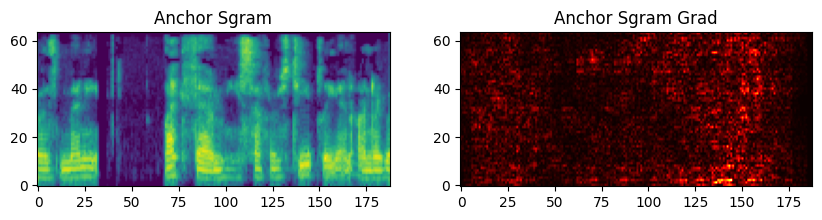

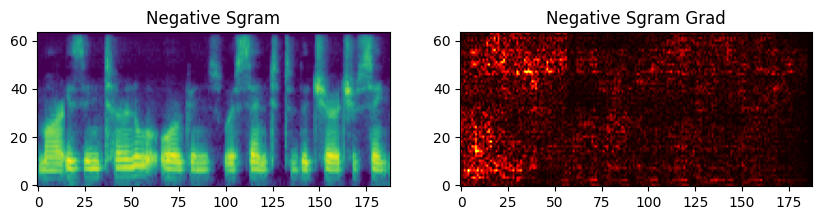

In [ ]:
anchor_sgram, posneg_sgram, lable = test_ds[15]
anchor_sgram_grad, posneg_sgram_grad = explain_model(siamese_model.cpu(), anchor_sgram=anchor_sgram, posneg_sgram=posneg_sgram)
plot_explain_siamese_model_all(anchor_sgram[0], posneg_sgram[0], anchor_sgram_grad, posneg_sgram_grad, lable)

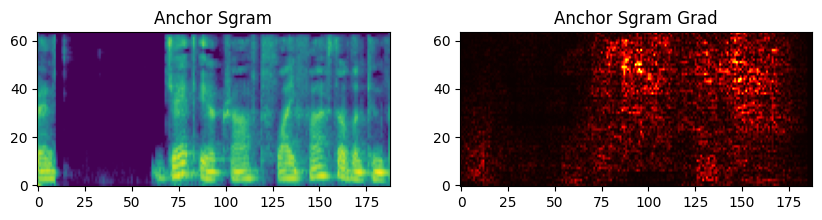

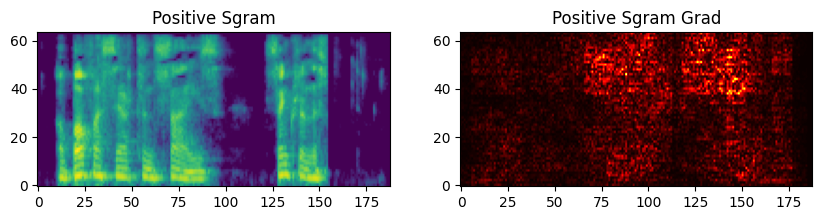

In [ ]:


anchor_sgram, posneg_sgram, label = train_ds[33]
anchor_sgram_grad, posneg_sgram_grad = explain_model(siamese_model.cpu(), anchor_sgram=anchor_sgram, posneg_sgram=posneg_sgram)
plot_explain_siamese_model_all(anchor_sgram[0], posneg_sgram[0], anchor_sgram_grad, posneg_sgram_grad, label)

In [ ]:
def test(model, dataloader, criterion, device='cpu'):
	model.eval()
	model.to(device)
	total_loss = 0.0
	predictions = []
	true_labels = []

	with torch.no_grad():
		for batch in tqdm(dataloader, desc="Evaluating", leave=False):
			anchor_sgram, posneg_sgram, label = batch
			anchor_sgram = anchor_sgram.to(device)
			posneg_sgram = posneg_sgram.to(device)
			label = label.to(device)
			output = model(anchor_sgram, posneg_sgram)
			loss = criterion(output, label)
			total_loss += loss.item()

			predictions += [torch.argmax(pred).item() for pred in output.cpu()]
			true_labels += [label.item() for label in label.cpu()]


	avg_loss = total_loss / len(dataloader)

	return avg_loss, true_labels, predictions

In [ ]:
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
def displayConfusionMatrix(true_labels, predictions):
	matrix = confusion_matrix(y_true=true_labels, y_pred= predictions, normalize="true" )
	disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels =  [ "Negative","Positive"]) 
	disp.plot(cmap=plt.cm.Blues) 
	plt.show()

In [ ]:
from src.dataset.base_dataset import BaseSoundDS


test_df = pd.read_csv(DATASET_PATH + "test_base_dataset.csv")
test_ds = BaseSoundDS(test_df, DATA_PATH + "validated_16000/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

accuracy: 0.6846473029045643


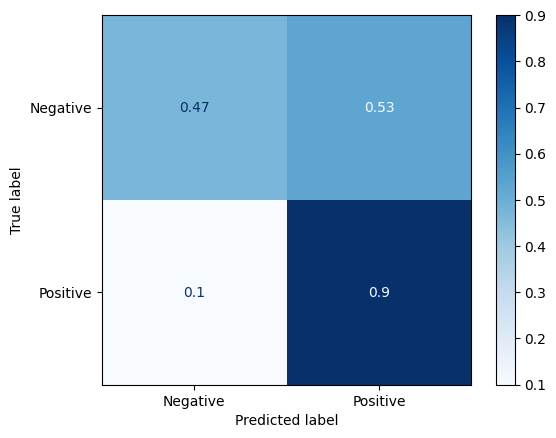

In [ ]:
avg_loss, true_labels, predictions = test(siamese_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [ ]:
from src.dataset.generated_dataset import GeneratedSoundDS

test_df = pd.read_csv(DATASET_PATH + "test_generated_dataset_.csv")
test_ds = GeneratedSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

accuracy: 0.8734439834024896


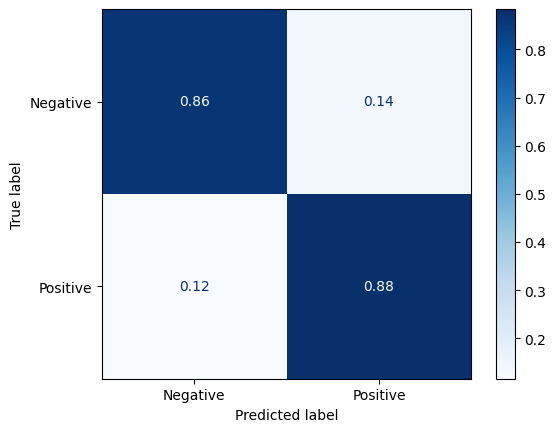

In [ ]:
avg_loss, true_labels, predictions = test(best_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [ ]:
from src.dataset.combined_dataset import CombinedSoundDS


test_df = pd.read_csv(DATASET_PATH + "test_combined_dataset.csv")
test_ds = CombinedSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)


accuracy: 0.8101659751037344


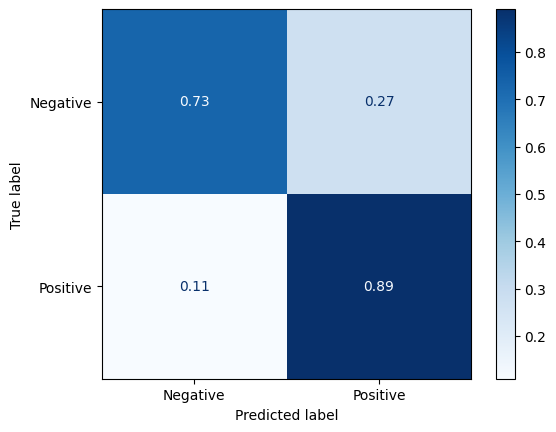

In [ ]:
avg_loss, true_labels, predictions = test(best_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [ ]:
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, CustomAdjustDurationTransform, ShiftWrapperTransform, ToMelSpectrogramTransform, AirAbsorptionWrapperTransform, EqualizerWrapperTransform
from src.transform.composite_transformation import CompositeTransformation
SAMPLE_RATE=16000
test_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3, padding_direction="start"),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
    AirAbsorptionWrapperTransform(),
    EqualizerWrapperTransform(),
		ToMelSpectrogramTransform(sample_rate=SAMPLE_RATE, n_mels=64, n_fft=512)
	]
)
test_df = pd.read_csv(DATASET_PATH + "test_combined_dataset.csv")
test_ds = CombinedSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/", transform = test_transform)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

Evaluating:   0%|          | 0/61 [00:00<?, ?it/s]

accuracy: 0.8215767634854771


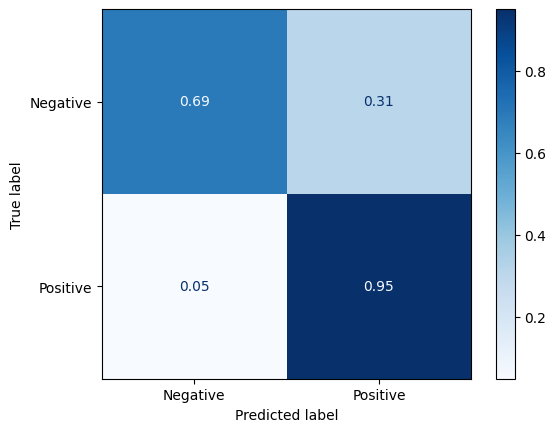

In [ ]:
avg_loss, true_labels, predictions = test(siamese_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [ ]:
audio_path = DATA_PATH + "KAGGLE/AUDIO/REAL"

In [ ]:
audio, sample_rate = librosa.load(audio_file, sr=self.sample_rate)
tt = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3, padding_direction="start"),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
    AirAbsorptionWrapperTransform(),
    EqualizerWrapperTransform(),
		ToMelSpectrogramTransform(sample_rate=SAMPLE_RATE, n_mels=64, n_fft=512)
	]
)

In [ ]:
def test(model, audio_path, criterion, device='cpu'):
	model.eval()
	model.to(device)
	total_loss = 0.0
	predictions = []
	true_labels = []

	with torch.no_grad():
		for batch in tqdm(dataloader, desc="Evaluating", leave=False):
			anchor_sgram, posneg_sgram, label = batch
			anchor_sgram = anchor_sgram.to(device)
			posneg_sgram = posneg_sgram.to(device)
			label = label.to(device)
			output = model(anchor_sgram, posneg_sgram)
			loss = criterion(output, label)
			total_loss += loss.item()

			predictions += [torch.argmax(pred).item() for pred in output.cpu()]
			true_labels += [label.item() for label in label.cpu()]


	avg_loss = total_loss / len(dataloader)

	return avg_loss, true_labels, predictions